<a href="https://colab.research.google.com/github/ohilikeit/-/blob/main/%EC%86%8C%EB%B9%84%20%EC%98%88%EC%B8%A1%20%EB%8C%80%ED%9A%8C%20ET%2BLGBM%2BXGB%2BGB%20with%20soft%20voting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install catboost
! pip install optuna

# 1. 데이터 로드

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
pd.set_option('mode.chained_assignment',  None)

In [97]:
train = pd.read_csv('/content/drive/MyDrive/Income/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Income/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/Income/sample_submission.csv')

- id : 샘플 아이디
- Year_Birth : 고객 생년월일
- Education : 고객 학력
- Marital_status : 고객 결혼 상태
- Income : 고객 연간 가구 소득
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- Dt_Customer : 고객이 회사에 등록한 날짜
- Recency : 고객의 마지막 구매 이후 일수
- NumDealsPurchases : 할인된 구매 횟수
- NumWebPurchases : 회사 웹사이트를 통한 구매 건수
- NumCatalogPurchases : 카탈로그를 사용한 구매 수 
- NumStorePuchases : 매장에서 직접 구매한 횟수
- NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
- AcceptedCmp1: 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp2: 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp3: 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp4: 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp5: 고객이 5번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
- Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- target : 고객의 제품 총 소비량

In [50]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


# 2. 전처리


In [51]:
# 범주형 변수 라벨 인코딩 
def make_label_map(dataframe): #라벨인코딩을 하기 위함 dictionary map 생성 함수
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps
def label_encoder(dataframe, label_map): # 각 범주형 변수에 인코딩 값을 부여하는 함수
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

# 전처리 함수 선언 
def preprocess(df):
    data = df.copy()
    # 1. Alone, YOLO, Absurd의 소수 클래스는 Single로 통일
    data = data.replace(['YOLO', 'Absurd', 'Alone'],'Single')

    # 2. 파생변수 생성
    data['income_per_childs'] = data['Income'] / (1 + data['Kidhome']) 
    data['Membership_period'] = np.log1p((pd.to_datetime('03-05-2022', format = '%d-%m-%Y') - pd.to_datetime(data['Dt_Customer'], format = '%d-%m-%Y')).dt.days)
    data['Age'] = 2022 - data['Year_Birth'] + 1
    data['total_purchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']
    data['purchase_per_visiting'] = data['total_purchases'] / (1 + data['NumWebVisitsMonth'])
    data = data.drop(['Year_Birth', 'Dt_Customer', 'id'], axis=1)
    data['group_age'] = data['Age'] // 10
    data.loc[data['group_age'] >= 8, 'group_age'] = 7
    data.loc[data['group_age'] <= 2, 'group_age'] = 3
    

    # 3. 범주형 변수 라벨 인코딩
    data = label_encoder(data, make_label_map(data))    
    
    return data

train = preprocess(train)
test = preprocess(test)

# 4. Age 이상치 제거 
idx = train[train['Age'] > 100].index
train.drop(idx, inplace=True)

In [52]:
# 실패작들 
'''
def robust(df):
    x_df = df.drop('target', axis=1)
    y_df = df['target']
    transformer.fit(x_df)
    transed_x_df = transformer.transform(x_df) 
    df = pd.DataFrame(transed_x_df, columns = x_df.columns)
    df = pd.concat([df, y_df], axis=1)

    return df

    if 'target' in data.columns:
        data = robust(data)
    else:
        transformer.fit(data)
        transed_data = transformer.transform(data) 
        data = pd.DataFrame(transed_data, columns = data.columns)

train['Cmp_total'] = train['AcceptedCmp1'] + train['AcceptedCmp2'] + train['AcceptedCmp3'] + train['AcceptedCmp4'] + train['AcceptedCmp5']
test['Cmp_total'] = test['AcceptedCmp1'] + test['AcceptedCmp2'] + test['AcceptedCmp3'] + test['AcceptedCmp4'] + test['AcceptedCmp5']
sns.countplot(train['Cmp_total'])

'''

"\ndef robust(df):\n    x_df = df.drop('target', axis=1)\n    y_df = df['target']\n    transformer.fit(x_df)\n    transed_x_df = transformer.transform(x_df) \n    df = pd.DataFrame(transed_x_df, columns = x_df.columns)\n    df = pd.concat([df, y_df], axis=1)\n\n    return df\n\n    if 'target' in data.columns:\n        data = robust(data)\n    else:\n        transformer.fit(data)\n        transed_data = transformer.transform(data) \n        data = pd.DataFrame(transed_data, columns = data.columns)\n\ntrain['Cmp_total'] = train['AcceptedCmp1'] + train['AcceptedCmp2'] + train['AcceptedCmp3'] + train['AcceptedCmp4'] + train['AcceptedCmp5']\ntest['Cmp_total'] = test['AcceptedCmp1'] + test['AcceptedCmp2'] + test['AcceptedCmp3'] + test['AcceptedCmp4'] + test['AcceptedCmp5']\nsns.countplot(train['Cmp_total'])\n\n"

# 3. EDA

In [ ]:
! pip install -U pandas-profiling

In [ ]:
import pandas_profiling
train.profile_report()

In [ ]:
categorical = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
               'Complain', 'Response']

quantitative = ['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'income_per_childs', 
       'Membership_period', 'Age', 'total_purchases', 'purchase_per_visiting']

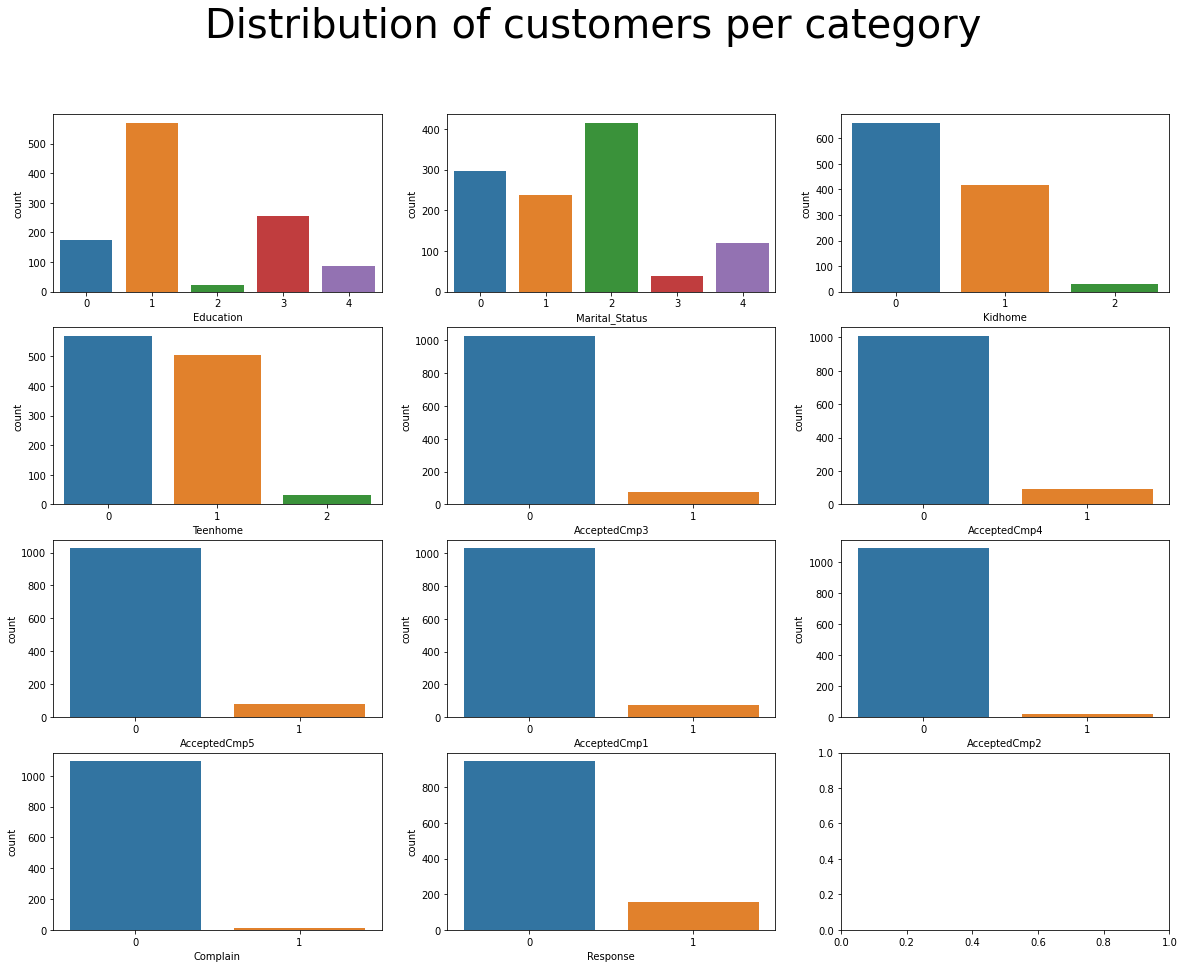

In [ ]:
# 1. 범주형 변수 시각화
fig, axes = plt.subplots(4, 3, figsize=(20,15))
fig.suptitle('Distribution of customers per category', fontsize=40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)
plt.show()

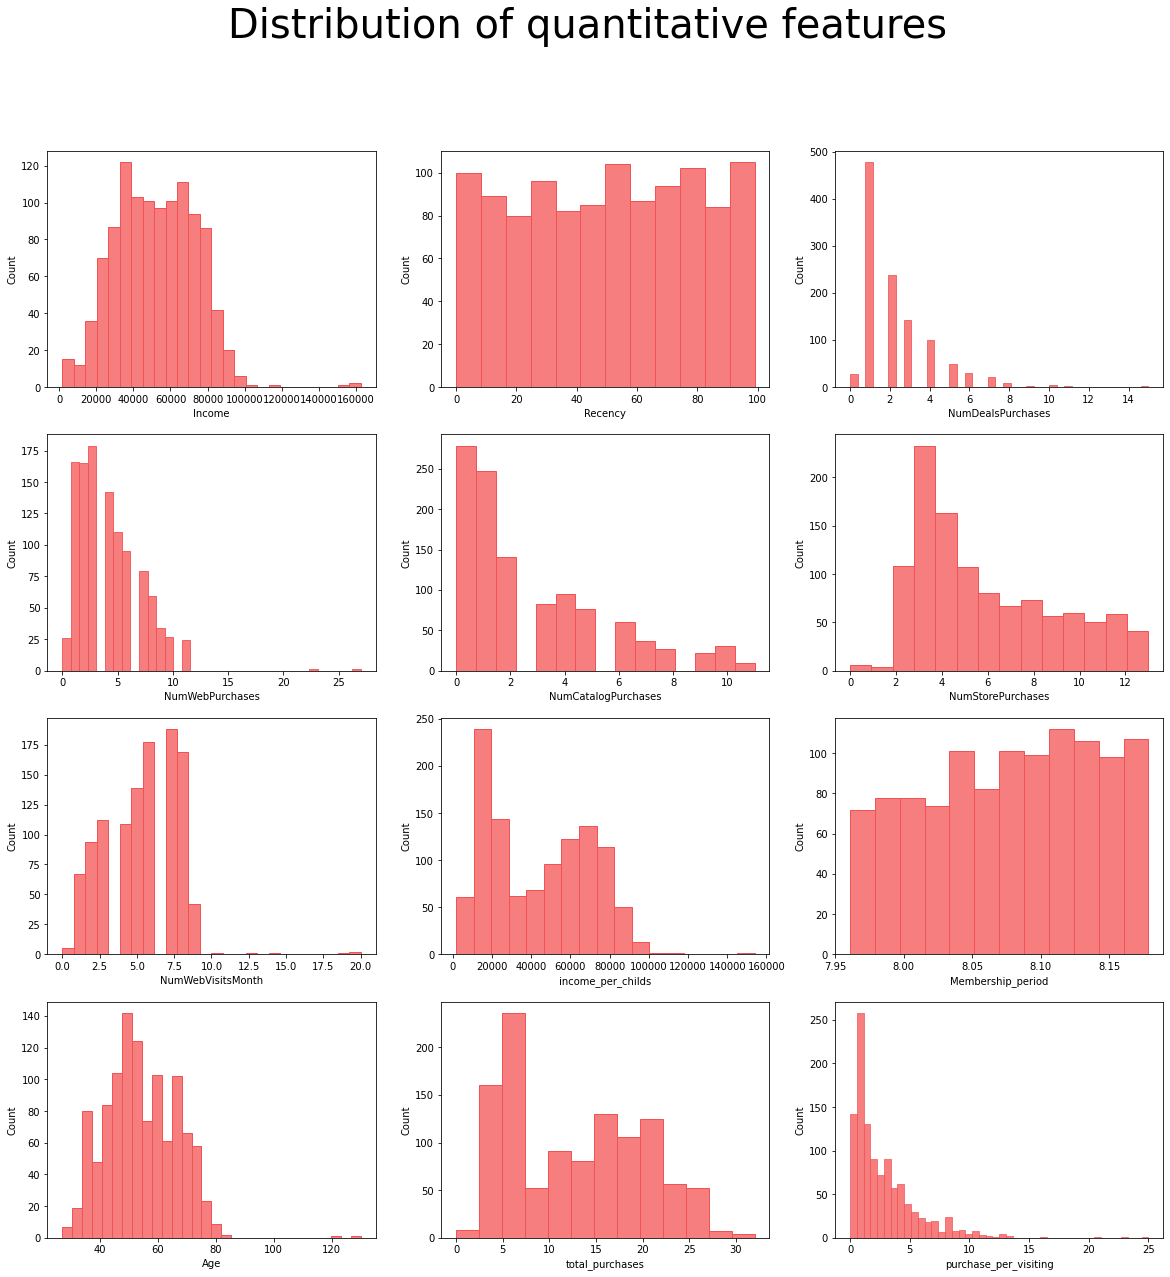

In [ ]:
# 2. 수치형 변수 시각화 

fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

# 4. 모델링

In [ ]:
! pip install catboost

In [59]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor

# 평가지표
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

## 1. ExtraTree

In [137]:
# 학습함수 정의 
def objective(trial: Trial, train):
    param = {
        'verbose' : 1,
        'random_state': 42,
        'n_jobs': -1,
        'max_depth' : trial.suggest_int('max_depth', 5, 50),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0, 0.3),
        'n_estimators':trial.suggest_int('n_estimators', 500, 3000),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0, 0.5)
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['target']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('target', axis=1)
        y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']

        model = ExtraTreesRegressor(**param)

        model.fit(X, y)
        score = NMAE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)


# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='ExtraTrees-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=70)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2648 out of 2648 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    0.6s
[Paral

Best trial : score 0.1668483192106885, 
params {'max_depth': 35, 'ccp_alpha': 0.07427735519516399, 'n_estimators': 2519, 'min_impurity_decrease': 0.05555227002822383}


In [138]:
optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프

In [139]:
optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화

In [140]:
# fitting 후 예측
X = train.drop('target', axis=1)
y = train['target']
ET = ExtraTreesRegressor(**study.best_trial.params)
Best_ET = ET.fit(X, y)
Best_ET_pred = Best_ET.predict(test).tolist()
Best_ET_pred[:5]

[550.6118830223635,
 890.7555114463413,
 860.5248775969295,
 1245.5698689956332,
 1305.673084557364]

In [141]:
submit['target'] = Best_ET_pred
submit.to_csv('/content/drive/MyDrive/Income/submit_ET.csv', index=False)

## 2. XGB

In [82]:
# 학습함수 정의 
def objective(trial: Trial, train):
    param = {
        'criterion' : 'absolute_error',
        'seed': 42, 
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators':trial.suggest_int('n_estimators', 500, 3000),        
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'max_depth' : trial.suggest_int('max_depth', 5, 40),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.2, 1),
        'min_split_loss' : trial.suggest_loguniform('min_split_loss', 1e-3, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),

    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['target']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('target', axis=1)
        y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']

        model = XGBRegressor(**param)

        model.fit(X, y)
        score = NMAE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)


# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='XGBRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=70)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-05-11 05:46:38,214] A new study created in memory with name: XGBRegressor-Hyperparameter-Tuning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:46:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:46:58,962] Trial 0 finished with value: 0.18996147711074468 and parameters: {'learning_rate': 0.03807947176588889, 'n_estimators': 2877, 'min_child_weight': 22, 'max_depth': 26, 'colsample_bytree': 0.3248149123539492, 'min_split_loss': 0.004207053950287938, 'lambda': 0.0017073967431528124, 'alpha': 2.9154431891537547}. Best is trial 0 with value: 0.18996147711074468.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:48:17,458] Trial 1 finished with value: 0.17745818173646044 and parameters: {'learning_rate': 0.06051038616257767, 'n_estimators': 2270, 'min_child_weight': 1, 'max_depth': 39, 'colsample_bytree': 0.8659541126403374, 'min_split_loss': 0.0070689749506246055, 'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254}. Best is trial 1 with value: 0.17745818173646044.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:48:37,991] Trial 2 finished with value: 0.17598771952945663 and parameters: {'learning_rate': 0.03111998205299424, 'n_estimators': 1812, 'min_child_weight': 13, 'max_depth': 15, 'colsample_bytree': 0.6894823157779035, 'min_split_loss': 0.003613894271216527, 'lambda': 0.01474275315991467, 'alpha': 0.029204338471814112}. Best is trial 2 with value: 0.17598771952945663.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:49:23,903] Trial 3 finished with value: 0.17288644608549247 and parameters: {'learning_rate': 0.04615092843748656, 'n_estimators': 2463, 'min_child_weight': 6, 'max_depth': 23, 'colsample_bytree': 0.6739316550896339, 'min_split_loss': 0.0015339162591163618, 'lambda': 0.26926469100861794, 'alpha': 0.004809461967501573}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:49:45,138] Trial 4 finished with value: 0.18661878460321152 and parameters: {'learning_rate': 0.0074401077055426725, 'n_estimators': 2873, 'min_child_weight': 29, 'max_depth': 34, 'colsample_bytree': 0.4436910153386966, 'min_split_loss': 0.002458603276328005, 'lambda': 0.5456725485601477, 'alpha': 0.057624872164786026}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:50:15,198] Trial 5 finished with value: 0.17777439162274886 and parameters: {'learning_rate': 0.013081785249633104, 'n_estimators': 1738, 'min_child_weight': 2, 'max_depth': 37, 'colsample_bytree': 0.40702398528001354, 'min_split_loss': 0.4467752817973907, 'lambda': 0.017654048052495083, 'alpha': 0.12030178871154672}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:50:28,802] Trial 6 finished with value: 0.1908266627602752 and parameters: {'learning_rate': 0.05512431765498469, 'n_estimators': 962, 'min_child_weight': 30, 'max_depth': 32, 'colsample_bytree': 0.9515991532513512, 'min_split_loss': 3.7958531426706403, 'lambda': 0.24637685958997463, 'alpha': 4.869640941520899}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:50:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:50:42,683] Trial 7 finished with value: 0.17340022678742215 and parameters: {'learning_rate': 0.00976075770314003, 'n_estimators': 990, 'min_child_weight': 2, 'max_depth': 16, 'colsample_bytree': 0.5109418317515857, 'min_split_loss': 0.01217295809836997, 'lambda': 2.0651425578959257, 'alpha': 0.026730883107816707}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:50:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:51:02,366] Trial 8 finished with value: 0.19067372566435745 and parameters: {'learning_rate': 0.028812516459050697, 'n_estimators': 1857, 'min_child_weight': 5, 'max_depth': 33, 'colsample_bytree': 0.2596405149438167, 'min_split_loss': 8.862326508576253, 'lambda': 1.2273800987852967, 'alpha': 0.0062353771356731605}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:51:25,519] Trial 9 finished with value: 0.18801549474925358 and parameters: {'learning_rate': 0.0015466895952366377, 'n_estimators': 2539, 'min_child_weight': 22, 'max_depth': 31, 'colsample_bytree': 0.8170162773487566, 'min_split_loss': 0.0019777828512462727, 'lambda': 0.02715581955282941, 'alpha': 0.0029072088906598446}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:51:27,720] Trial 10 finished with value: 0.17723005697546604 and parameters: {'learning_rate': 0.09229253483114684, 'n_estimators': 514, 'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.6524904725451227, 'min_split_loss': 0.05096260057375795, 'lambda': 6.903717055434713, 'alpha': 0.001115347973270347}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:51:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:51:42,110] Trial 11 finished with value: 0.17455434189287442 and parameters: {'learning_rate': 0.07472142904562284, 'n_estimators': 1264, 'min_child_weight': 8, 'max_depth': 17, 'colsample_bytree': 0.5257811053788692, 'min_split_loss': 0.026036310988103335, 'lambda': 3.151487111158106, 'alpha': 0.4084036074410788}. Best is trial 3 with value: 0.17288644608549247.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:51:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:51:58,994] Trial 12 finished with value: 0.17249581606655062 and parameters: {'learning_rate': 0.043284118257699865, 'n_estimators': 1241, 'min_child_weight': 7, 'max_depth': 19, 'colsample_bytree': 0.5670916687954505, 'min_split_loss': 0.015442490344523128, 'lambda': 0.14807663692512263, 'alpha': 0.013498826137427243}. Best is trial 12 with value: 0.17249581606655062.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:51:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:52:23,029] Trial 13 finished with value: 0.18134044999428653 and parameters: {'learning_rate': 0.07041509694398224, 'n_estimators': 1532, 'min_child_weight': 16, 'max_depth': 22, 'colsample_bytree': 0.7208126425372757, 'min_split_loss': 0.23641893216272417, 'lambda': 0.08366948694386878, 'alpha': 0.013181471685130085}. Best is trial 12 with value: 0.17249581606655062.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:52:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:52:56,849] Trial 14 finished with value: 0.17207267382457037 and parameters: {'learning_rate': 0.04223214223750964, 'n_estimators': 2211, 'min_child_weight': 8, 'max_depth': 23, 'colsample_bytree': 0.5720615367693, 'min_split_loss': 0.0012268275456693623, 'lambda': 0.07054382978969141, 'alpha': 0.0010503028500028942}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:52:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:53:11,840] Trial 15 finished with value: 0.1754064973566743 and parameters: {'learning_rate': 0.02598397612704956, 'n_estimators': 2128, 'min_child_weight': 13, 'max_depth': 10, 'colsample_bytree': 0.5618610503020868, 'min_split_loss': 0.019097413881711142, 'lambda': 0.08326105536377067, 'alpha': 0.0010252108699425019}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:53:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:53:26,173] Trial 16 finished with value: 0.1816329148966655 and parameters: {'learning_rate': 0.04085371161660414, 'n_estimators': 1379, 'min_child_weight': 18, 'max_depth': 27, 'colsample_bytree': 0.4256679896618074, 'min_split_loss': 0.1103195825253561, 'lambda': 0.03967488082445049, 'alpha': 0.36130491130956593}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:53:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:53:36,163] Trial 17 finished with value: 0.17268239105241512 and parameters: {'learning_rate': 0.06274054056224267, 'n_estimators': 610, 'min_child_weight': 10, 'max_depth': 20, 'colsample_bytree': 0.7775563844485625, 'min_split_loss': 0.8088332704222078, 'lambda': 0.2751281803960879, 'alpha': 0.002392941437975146}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:53:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:53:54,869] Trial 18 finished with value: 0.17458127098734072 and parameters: {'learning_rate': 0.08719217211404201, 'n_estimators': 2067, 'min_child_weight': 5, 'max_depth': 12, 'colsample_bytree': 0.6042156853543582, 'min_split_loss': 0.06406758195385384, 'lambda': 0.008288764709950006, 'alpha': 0.012607766003033899}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:53:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:54:05,104] Trial 19 finished with value: 0.180033597800557 and parameters: {'learning_rate': 0.020748639275882354, 'n_estimators': 1052, 'min_child_weight': 12, 'max_depth': 26, 'colsample_bytree': 0.3450326011133374, 'min_split_loss': 0.005849606369742678, 'lambda': 0.0027726410695743456, 'alpha': 0.15709030968383952}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:54:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:54:24,199] Trial 20 finished with value: 0.17398784997044678 and parameters: {'learning_rate': 0.04677297036830346, 'n_estimators': 1565, 'min_child_weight': 7, 'max_depth': 19, 'colsample_bytree': 0.48560284246401514, 'min_split_loss': 0.013430781289546029, 'lambda': 0.713776796451712, 'alpha': 1.3547070929252183}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:54:33,867] Trial 21 finished with value: 0.1738102361156031 and parameters: {'learning_rate': 0.06463377999410523, 'n_estimators': 572, 'min_child_weight': 10, 'max_depth': 21, 'colsample_bytree': 0.7540321192569499, 'min_split_loss': 0.8131095290595376, 'lambda': 0.19534573878376868, 'alpha': 0.0019057015935661367}. Best is trial 14 with value: 0.17207267382457037.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:54:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:54:42,054] Trial 22 finished with value: 0.17107548702452532 and parameters: {'learning_rate': 0.07965107063843134, 'n_estimators': 770, 'min_child_weight': 9, 'max_depth': 12, 'colsample_bytree': 0.7855335542263048, 'min_split_loss': 1.4601877530585692, 'lambda': 0.05293251692245394, 'alpha': 0.002214134368670224}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:54:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:54:49,680] Trial 23 finished with value: 0.17560965270365905 and parameters: {'learning_rate': 0.08300179602002662, 'n_estimators': 810, 'min_child_weight': 4, 'max_depth': 11, 'colsample_bytree': 0.6124331030004094, 'min_split_loss': 0.0012028038828741899, 'lambda': 0.05005674401601978, 'alpha': 0.010178774374616341}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:54:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:54:59,513] Trial 24 finished with value: 0.17306978200525264 and parameters: {'learning_rate': 0.05378385739188291, 'n_estimators': 1242, 'min_child_weight': 8, 'max_depth': 7, 'colsample_bytree': 0.9763038439214442, 'min_split_loss': 1.4184315482741328, 'lambda': 0.08389146329800143, 'alpha': 0.0025490301899204508}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:55:08,786] Trial 25 finished with value: 0.18092706303244185 and parameters: {'learning_rate': 0.09993005423129349, 'n_estimators': 748, 'min_child_weight': 17, 'max_depth': 14, 'colsample_bytree': 0.8518617924047084, 'min_split_loss': 2.7408426692987007, 'lambda': 0.15798875231434903, 'alpha': 0.028487795035375026}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:55:26,867] Trial 26 finished with value: 0.17810659308841298 and parameters: {'learning_rate': 0.03453521579060478, 'n_estimators': 1129, 'min_child_weight': 14, 'max_depth': 18, 'colsample_bytree': 0.9066977112888315, 'min_split_loss': 0.13643012663520188, 'lambda': 0.03548764366821345, 'alpha': 0.0010602650298815845}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:55:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:55:39,315] Trial 27 finished with value: 0.17504713924388754 and parameters: {'learning_rate': 0.07566115197170042, 'n_estimators': 808, 'min_child_weight': 9, 'max_depth': 24, 'colsample_bytree': 0.5824216643969952, 'min_split_loss': 0.040700548104481316, 'lambda': 0.6105183722705176, 'alpha': 0.004127090889286493}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:55:48,685] Trial 28 finished with value: 0.18101827959996603 and parameters: {'learning_rate': 0.04255149900640646, 'n_estimators': 1495, 'min_child_weight': 20, 'max_depth': 8, 'colsample_bytree': 0.650040192730914, 'min_split_loss': 0.3366762025099479, 'lambda': 0.014677960018045756, 'alpha': 0.008870239532018908}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:55:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:56:27,107] Trial 29 finished with value: 0.182407585544705 and parameters: {'learning_rate': 0.05137125457895807, 'n_estimators': 2935, 'min_child_weight': 4, 'max_depth': 26, 'colsample_bytree': 0.3609493306190225, 'min_split_loss': 0.007123953690585713, 'lambda': 0.13809235586524352, 'alpha': 0.0016954466951672727}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:56:41,289] Trial 30 finished with value: 0.1926711612065622 and parameters: {'learning_rate': 0.03788402023587215, 'n_estimators': 2688, 'min_child_weight': 11, 'max_depth': 13, 'colsample_bytree': 0.21184693185513076, 'min_split_loss': 6.111781182391528, 'lambda': 0.001482452273022682, 'alpha': 0.02184413809340367}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:56:53,428] Trial 31 finished with value: 0.17232872206072614 and parameters: {'learning_rate': 0.0630549426989279, 'n_estimators': 666, 'min_child_weight': 7, 'max_depth': 21, 'colsample_bytree': 0.7577642302158689, 'min_split_loss': 1.137078357330994, 'lambda': 0.3520028243227251, 'alpha': 0.002619995990581515}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:57:08,564] Trial 32 finished with value: 0.17181281074905336 and parameters: {'learning_rate': 0.06874864070753456, 'n_estimators': 726, 'min_child_weight': 7, 'max_depth': 24, 'colsample_bytree': 0.7951481103949198, 'min_split_loss': 2.7184903664359883, 'lambda': 0.37473038997567515, 'alpha': 0.003569053861510694}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:57:29,120] Trial 33 finished with value: 0.1714131305403708 and parameters: {'learning_rate': 0.0691616663562468, 'n_estimators': 734, 'min_child_weight': 3, 'max_depth': 29, 'colsample_bytree': 0.8004543611702133, 'min_split_loss': 1.6314955771332222, 'lambda': 0.40368101256371375, 'alpha': 0.0034329639732717863}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:57:57,905] Trial 34 finished with value: 0.1796514410262172 and parameters: {'learning_rate': 0.08034208603990278, 'n_estimators': 892, 'min_child_weight': 1, 'max_depth': 28, 'colsample_bytree': 0.8817186045605634, 'min_split_loss': 1.9125498773505076, 'lambda': 1.1957428903696368, 'alpha': 0.005344870450283738}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:57:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 05:58:56,919] Trial 35 finished with value: 0.1711209377606658 and parameters: {'learning_rate': 0.06975759953751225, 'n_estimators': 2275, 'min_child_weight': 4, 'max_depth': 29, 'colsample_bytree': 0.8006338627583557, 'min_split_loss': 3.4631118083759205, 'lambda': 0.057335149799533705, 'alpha': 0.05801456067327218}. Best is trial 22 with value: 0.17107548702452532.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[05:58:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:59:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:59:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:59:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:00:02,626] Trial 36 finished with value: 0.17098882153146536 and parameters: {'learning_rate': 0.06865342186269903, 'n_estimators': 2385, 'min_child_weight': 3, 'max_depth': 29, 'colsample_bytree': 0.8068420840945556, 'min_split_loss': 4.090150302549995, 'lambda': 0.4084051338593803, 'alpha': 0.04459420938475222}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:00:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:01:10,621] Trial 37 finished with value: 0.17410972154050725 and parameters: {'learning_rate': 0.05859661686694005, 'n_estimators': 2325, 'min_child_weight': 3, 'max_depth': 30, 'colsample_bytree': 0.8361441131608867, 'min_split_loss': 5.357769914387515, 'lambda': 0.006295040021089724, 'alpha': 0.04865058486579384}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:01:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:02:19,526] Trial 38 finished with value: 0.18034996112104582 and parameters: {'learning_rate': 0.08928806612492265, 'n_estimators': 1960, 'min_child_weight': 1, 'max_depth': 36, 'colsample_bytree': 0.9224041966719558, 'min_split_loss': 0.5390741695769438, 'lambda': 0.02077200539874605, 'alpha': 0.07666324757736871}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:02:50,775] Trial 39 finished with value: 0.18624930763868974 and parameters: {'learning_rate': 0.07686658366344784, 'n_estimators': 2704, 'min_child_weight': 27, 'max_depth': 29, 'colsample_bytree': 0.7009206304647556, 'min_split_loss': 7.909151576762114, 'lambda': 0.7597863946075343, 'alpha': 0.2940510605672761}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:03:57,278] Trial 40 finished with value: 0.17375971163208628 and parameters: {'learning_rate': 0.06889408291826055, 'n_estimators': 2445, 'min_child_weight': 3, 'max_depth': 40, 'colsample_bytree': 0.7254152277372442, 'min_split_loss': 3.784251476467873, 'lambda': 2.305524235877855, 'alpha': 0.9993137782667413}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:04:50,381] Trial 41 finished with value: 0.17203795617992787 and parameters: {'learning_rate': 0.07022992006629956, 'n_estimators': 2338, 'min_child_weight': 5, 'max_depth': 25, 'colsample_bytree': 0.8226720085327952, 'min_split_loss': 2.3402543784250027, 'lambda': 0.38465161752678767, 'alpha': 0.04014004039660744}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:05:10,640] Trial 42 finished with value: 0.1711390109349364 and parameters: {'learning_rate': 0.057873686235068646, 'n_estimators': 703, 'min_child_weight': 3, 'max_depth': 36, 'colsample_bytree': 0.7942409221303726, 'min_split_loss': 3.4260588438790642, 'lambda': 0.44671457337691295, 'alpha': 0.18798957880784398}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:06:34,239] Trial 43 finished with value: 0.17306681054693504 and parameters: {'learning_rate': 0.05670538103470772, 'n_estimators': 2603, 'min_child_weight': 3, 'max_depth': 35, 'colsample_bytree': 0.8770545265086576, 'min_split_loss': 4.176811543845327, 'lambda': 0.061093749898110714, 'alpha': 0.1531687774788019}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:06:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:06:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:07:27,686] Trial 44 finished with value: 0.17779682226463447 and parameters: {'learning_rate': 0.0654063799318518, 'n_estimators': 1687, 'min_child_weight': 1, 'max_depth': 33, 'colsample_bytree': 0.8050005613452487, 'min_split_loss': 1.521111520714276, 'lambda': 1.1177782010043633, 'alpha': 0.12000051232654042}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:07:53,512] Trial 45 finished with value: 0.17542120912644382 and parameters: {'learning_rate': 0.08481535987528012, 'n_estimators': 917, 'min_child_weight': 5, 'max_depth': 32, 'colsample_bytree': 0.9278934841777153, 'min_split_loss': 9.662473630335652, 'lambda': 0.11777259056906593, 'alpha': 0.5818781595572647}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:07:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:09:16,223] Trial 46 finished with value: 0.17637860816743278 and parameters: {'learning_rate': 0.07363442778440117, 'n_estimators': 2810, 'min_child_weight': 2, 'max_depth': 37, 'colsample_bytree': 0.7459107434044605, 'min_split_loss': 1.0121807871559845, 'lambda': 0.2374438467988194, 'alpha': 0.2473251854384547}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:09:31,405] Trial 47 finished with value: 0.1761153737402786 and parameters: {'learning_rate': 0.0948580385463129, 'n_estimators': 519, 'min_child_weight': 6, 'max_depth': 38, 'colsample_bytree': 0.9967429076289462, 'min_split_loss': 0.5587188377096224, 'lambda': 0.4531481131266145, 'alpha': 9.488721648613684}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:09:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:09:54,410] Trial 48 finished with value: 0.17318785516617838 and parameters: {'learning_rate': 0.07997600480534796, 'n_estimators': 1047, 'min_child_weight': 4, 'max_depth': 29, 'colsample_bytree': 0.6639417763620495, 'min_split_loss': 3.950160858329033, 'lambda': 0.012156929082982508, 'alpha': 0.020012919818771048}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:09:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:10:39,645] Trial 49 finished with value: 0.17224802065015837 and parameters: {'learning_rate': 0.06007571486377269, 'n_estimators': 1918, 'min_child_weight': 6, 'max_depth': 34, 'colsample_bytree': 0.7821069515062583, 'min_split_loss': 6.231395548934182, 'lambda': 7.599406856457576, 'alpha': 0.08472378168850873}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:10:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:11:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:11:45,549] Trial 50 finished with value: 0.17162509135309914 and parameters: {'learning_rate': 0.04732493712652382, 'n_estimators': 2423, 'min_child_weight': 2, 'max_depth': 31, 'colsample_bytree': 0.6982290534727341, 'min_split_loss': 0.23373003451082416, 'lambda': 2.333433917166122, 'alpha': 0.006657457188364865}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:11:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:11:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:12:51,825] Trial 51 finished with value: 0.1717463262801707 and parameters: {'learning_rate': 0.05201602118233527, 'n_estimators': 2422, 'min_child_weight': 2, 'max_depth': 32, 'colsample_bytree': 0.7009525642777891, 'min_split_loss': 0.2717005796276615, 'lambda': 4.057635393433018, 'alpha': 0.005945837424811552}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:13:57,025] Trial 52 finished with value: 0.1757234229553573 and parameters: {'learning_rate': 0.048241322576213344, 'n_estimators': 2237, 'min_child_weight': 3, 'max_depth': 30, 'colsample_bytree': 0.8509256884158977, 'min_split_loss': 1.8766480723775114, 'lambda': 1.8364790409577734, 'alpha': 0.03548221088530229}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:13:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:14:56,958] Trial 53 finished with value: 0.17502366602881664 and parameters: {'learning_rate': 0.0667054597911799, 'n_estimators': 2109, 'min_child_weight': 1, 'max_depth': 28, 'colsample_bytree': 0.7268721175315468, 'min_split_loss': 2.960239299142424, 'lambda': 3.6070353370139427, 'alpha': 0.06207681692398869}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:14:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:15:52,385] Trial 54 finished with value: 0.1730513814836001 and parameters: {'learning_rate': 0.0729577589666543, 'n_estimators': 2497, 'min_child_weight': 4, 'max_depth': 30, 'colsample_bytree': 0.6335867645832551, 'min_split_loss': 0.17661907524642487, 'lambda': 0.9597760597716138, 'alpha': 0.008736372467651486}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:17:03,966] Trial 55 finished with value: 0.17423845746073469 and parameters: {'learning_rate': 0.06049399023331245, 'n_estimators': 2590, 'min_child_weight': 2, 'max_depth': 27, 'colsample_bytree': 0.7789384462970216, 'min_split_loss': 0.6476730002039418, 'lambda': 0.026652539591357608, 'alpha': 0.018832107903384184}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:17:46,941] Trial 56 finished with value: 0.17345854185501156 and parameters: {'learning_rate': 0.07829025545070643, 'n_estimators': 2010, 'min_child_weight': 6, 'max_depth': 34, 'colsample_bytree': 0.6801753123349226, 'min_split_loss': 1.178564039738909, 'lambda': 0.1064046758963779, 'alpha': 0.23376597032821872}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:18:35,341] Trial 57 finished with value: 0.17268555122295984 and parameters: {'learning_rate': 0.05410374538837339, 'n_estimators': 2180, 'min_child_weight': 9, 'max_depth': 31, 'colsample_bytree': 0.8158332013035647, 'min_split_loss': 1.9613991378923898, 'lambda': 5.075119070822825, 'alpha': 0.0014008498527824868}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:19:26,173] Trial 58 finished with value: 0.17357720988054187 and parameters: {'learning_rate': 0.07222515102536835, 'n_estimators': 1785, 'min_child_weight': 5, 'max_depth': 36, 'colsample_bytree': 0.8924606109811365, 'min_split_loss': 5.171648825821128, 'lambda': 1.595823244090904, 'alpha': 0.5283994143059434}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:19:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:19:57,558] Trial 59 finished with value: 0.18826369566073614 and parameters: {'learning_rate': 0.05683457810192425, 'n_estimators': 2382, 'min_child_weight': 27, 'max_depth': 39, 'colsample_bytree': 0.755398692993523, 'min_split_loss': 0.41539789558029094, 'lambda': 0.20521015869516823, 'alpha': 0.0034900001709814656}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:19:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:20:09,316] Trial 60 finished with value: 0.17344497549890467 and parameters: {'learning_rate': 0.046764312852506956, 'n_estimators': 649, 'min_child_weight': 3, 'max_depth': 16, 'colsample_bytree': 0.8569446245996427, 'min_split_loss': 0.07816837973136917, 'lambda': 0.044596093480287445, 'alpha': 0.17357100923169339}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:20:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:21:22,586] Trial 61 finished with value: 0.17351476718795966 and parameters: {'learning_rate': 0.05006217148108838, 'n_estimators': 2683, 'min_child_weight': 2, 'max_depth': 32, 'colsample_bytree': 0.6977065554433792, 'min_split_loss': 0.2751358980996731, 'lambda': 2.7379024391331663, 'alpha': 0.005070539114829202}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:21:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:21:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:21:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:22:24,724] Trial 62 finished with value: 0.17254744837930822 and parameters: {'learning_rate': 0.05339548645510179, 'n_estimators': 2266, 'min_child_weight': 2, 'max_depth': 33, 'colsample_bytree': 0.7062649700151237, 'min_split_loss': 0.20031183257256455, 'lambda': 4.394424182528041, 'alpha': 0.005718065210405629}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:23:25,360] Trial 63 finished with value: 0.1747308764672802 and parameters: {'learning_rate': 0.06270964963726117, 'n_estimators': 2428, 'min_child_weight': 4, 'max_depth': 31, 'colsample_bytree': 0.7321010940279429, 'min_split_loss': 0.8818705689990046, 'lambda': 0.6110688462886784, 'alpha': 0.0020193352472810413}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:23:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:24:55,056] Trial 64 finished with value: 0.17564794354562946 and parameters: {'learning_rate': 0.06596865843707665, 'n_estimators': 2801, 'min_child_weight': 1, 'max_depth': 35, 'colsample_bytree': 0.8002086765945423, 'min_split_loss': 3.3615953542290575, 'lambda': 8.814894129984348, 'alpha': 0.014320726997626546}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:25:13,376] Trial 65 finished with value: 0.17416319594882426 and parameters: {'learning_rate': 0.04531145293662969, 'n_estimators': 820, 'min_child_weight': 8, 'max_depth': 28, 'colsample_bytree': 0.8305739062964046, 'min_split_loss': 0.12883537578765716, 'lambda': 1.5509951659705767, 'alpha': 0.006832790166106715}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:25:52,292] Trial 66 finished with value: 0.17710093573894103 and parameters: {'learning_rate': 0.039111245311808006, 'n_estimators': 2168, 'min_child_weight': 14, 'max_depth': 25, 'colsample_bytree': 0.7660980845068033, 'min_split_loss': 1.6443845902738656, 'lambda': 5.017906186691668, 'alpha': 0.003886583840324832}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:25:58,196] Trial 67 finished with value: 0.17584972749701552 and parameters: {'learning_rate': 0.08279924762968416, 'n_estimators': 1140, 'min_child_weight': 5, 'max_depth': 5, 'colsample_bytree': 0.7924758080788289, 'min_split_loss': 0.3382426802012237, 'lambda': 0.060794186927753506, 'alpha': 0.007007940904293361}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:26:30,786] Trial 68 finished with value: 0.17350933650589245 and parameters: {'learning_rate': 0.050918815260381174, 'n_estimators': 1347, 'min_child_weight': 3, 'max_depth': 32, 'colsample_bytree': 0.6311317508506118, 'min_split_loss': 0.7336947599176986, 'lambda': 0.8410247236024657, 'alpha': 0.0014323845595981244}. Best is trial 36 with value: 0.17098882153146536.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[06:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-05-11 06:27:25,036] Trial 69 finished with value: 0.17228083988491869 and parameters: {'learning_rate': 0.05858397626596159, 'n_estimators': 2561, 'min_child_weight': 6, 'max_depth': 35, 'colsample_bytree': 0.6745140186330019, 'min_split_loss': 7.22985454642547, 'lambda': 0.031219019230330606, 'alpha': 0.10335422885764045}. Best is trial 36 with value: 0.17098882153146536.


Best trial : score 0.17098882153146536, 
params {'learning_rate': 0.06865342186269903, 'n_estimators': 2385, 'min_child_weight': 3, 'max_depth': 29, 'colsample_bytree': 0.8068420840945556, 'min_split_loss': 4.090150302549995, 'lambda': 0.4084051338593803, 'alpha': 0.04459420938475222}


In [83]:
optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프

In [84]:
optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화

In [85]:
# fitting 후 예측
X = train.drop('target', axis=1)
y = train['target']
XGB = XGBRegressor(**study.best_trial.params)
Best_XGB = XGB.fit(X, y)
Best_XGB_pred = Best_XGB.predict(test).tolist()
Best_XGB_pred[:5]

[06:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[527.4630737304688,
 918.248291015625,
 854.6306762695312,
 1241.865966796875,
 1202.77978515625]

## 3. LGBM

In [78]:
# 학습함수 정의 
def objective(trial: Trial, train):

    param = {
        'objective': 'regression',
        'verbose' : -1,
        'metric' : 'mae',
        'random_state': 42, 
        'n_jobs': -1,
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
        'num_leaves' : trial.suggest_int('num_leaves', 5, 30),
        'min_child_samples' : trial.suggest_int('min_child_samples', 2, 10),
        'reg_alpha' : trial.suggest_float('reg_alpha', 1, 1.3),
        'reg_lambda' : trial.suggest_float('reg_lambda', 1, 1.3)
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['target']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('target', axis=1)
        y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']

        model = LGBMRegressor(**param)

        model.fit(X, y)
        score = NMAE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='LGBM-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=100)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-05-11 05:34:44,681] A new study created in memory with name: LGBM-Hyperparameter-Tuning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2022-05-11 05:34:48,382] Trial 0 finished with value: 0.1732358276463734 and parameters: {'colsample_bytree': 0.8123620356542087, 'max_depth': 29, 'n_estimators': 2330, 'learning_rate': 0.030334265725654796, 'num_leaves': 9, 'min_child_samples': 3, 'reg_alpha': 1.01742508365046, 'reg_lambda': 1.2598528437324805}. Best is trial 0 with value: 0.1732358276463734.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2022-05-11 05:34:50,685] Trial 1 finished with value: 0.17092542760761714 and parameters: {'colsample_bytree': 0.8803345035229626, 'max_depth': 22, 'n_estimators': 551, 'learning_rate':

Best trial : score 0.16606027186040742, 
params {'colsample_bytree': 0.782127188550706, 'max_depth': 12, 'n_estimators': 1176, 'learning_rate': 0.03867423222552158, 'num_leaves': 28, 'min_child_samples': 4, 'reg_alpha': 1.296434082549746, 'reg_lambda': 1.1111421262169932}


In [79]:
optuna.visualization.plot_param_importances(study)

In [80]:
optuna.visualization.plot_optimization_history(study)

In [81]:
# fitting 후 예측
X = train.drop('target', axis=1)
y = train['target']
lgbm = LGBMRegressor(**study.best_trial.params)
Best_LGBM = lgbm.fit(X, y)
Best_LGBM_pred = Best_LGBM.predict(test).tolist()
Best_LGBM_pred[:5]

[556.8935112320393,
 746.559076501798,
 821.7865243384407,
 1150.8083876368123,
 1288.7174669560618]

## 4. GradientBoost

In [73]:
# 학습함수 정의 
def objective(trial: Trial, train):

    param = {
        'verbose' : 0,
        'random_state': 42,
        #'loss' : 'absolute_error',
        'n_estimators' : trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0, 0.2),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0, 0.3)
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['target']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('target', axis=1)
        y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']

        model = GradientBoostingRegressor(**param)

        model.fit(X, y)
        score = NMAE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='GB-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=70)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-05-11 04:42:12,005] A new study created in memory with name: GB-Hyperparameter-Tuning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2022-05-11 04:43:25,769] Trial 0 finished with value: 0.21552743573360633 and parameters: {'n_estimators': 1436, 'learning_rate': 0.0951207163345817, 'min_impurity_decrease': 0.146398788362281, 'max_depth': 19, 'ccp_alpha': 0.04680559213273095}. Best is trial 0 with value: 0.21552743573360633.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[I 2022-05-11 04:44:12,478] Trial 1 finished with value: 0.21019048514025135 and parameters: {'n_estimators': 890, 'learning_rate': 0.006750277604651747, 'min_impurity_decrease': 0.17323522915498704, 'max_depth': 19, 'ccp_alpha': 0.21242177333881365}. Best i

Best trial : score 0.17118179991976665, 
params {'n_estimators': 1854, 'learning_rate': 0.08486287946377817, 'min_impurity_decrease': 0.05764559348364739, 'max_depth': 6, 'ccp_alpha': 0.22959907212031092}


In [74]:
optuna.visualization.plot_param_importances(study)

In [75]:
optuna.visualization.plot_optimization_history(study)

In [77]:
# fitting 후 예측
X = train.drop('target', axis=1)
y = train['target']
gb = GradientBoostingRegressor(**study.best_trial.params)
Best_GB = gb.fit(X, y)
Best_GB_pred = Best_GB.predict(test).tolist()
Best_GB_pred[:10]

[492.64515793727753,
 807.978731094506,
 895.7993140369509,
 1222.6296093199007,
 944.4074840278897,
 1050.45011663335,
 61.09731431009586,
 1161.9287022977526,
 1598.4097147528025,
 68.26366083478331]

## 5. RandomForest

In [ ]:
# 학습함수 정의 
def objective(trial: Trial, train):

    param = {
        'verbose' : 1,
        'random_state': 42, 
        'n_jobs': -1,
        'criterion' : 'absolute_error',
        'n_estimators' : trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth' : trial.suggest_int('max_depth', 10, 30),
        'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0, 0.2),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0, 0.1)        
    }
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['target']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('target', axis=1)
        y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']

        model = RandomForestRegressor(**param)

        model.fit(X, y)
        score = NMAE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='RF-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial,train), 
               n_trials=70)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# fitting 후 예측
X = train.drop('target', axis=1)
y = train['target']
rf = RandomForestRegressor(**study.best_trial.params)
Best_RF = rf.fit(X, y)
Best_RF_pred = Best_RF.predict(test).tolist()
Best_RF_pred[:5]

## 6. 앙상블

### 1) 단순 평균내기

In [142]:
best = (pd.DataFrame(Best_ET_pred) + pd.DataFrame(Best_XGB_pred) + pd.DataFrame(Best_LGBM_pred) + pd.DataFrame(Best_GB_pred)) / 4
submit['target'] = best[0]
submit.to_csv('/content/drive/MyDrive/Income/submit_mean.csv', index=False)

### 2) Voting 기법

In [143]:
# https://hyemin-kim.github.io/2020/08/04/S-Python-sklearn4/#%ED%9A%8C%EA%B7%80-regression
from sklearn.ensemble import VotingRegressor

# voting 참여 single models 정의
single_models = [
                 ('ExtratreesRegressor', ET),
                 ('XGBRegressor', XGB),
                 ('LGBMRegressor', lgbm),
                 ('GradientBoostRegressor', gb)
]

# voting regressor 만들기
X = train.drop('target', axis=1)
y = train['target']
voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(X,y)

# predcit & submission
voting_pred = voting_regressor.predict(test)
submit['target'] = voting_pred.tolist()
submit.to_csv('/content/drive/MyDrive/Income/submit_voting.csv', index=False)

In [144]:
# K-Fold 
def kfold(model, train, scale=False):
    cv_accuracy = []
    cv = StratifiedKFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(train, train['target']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('target', axis=1)
        y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']

        model.fit(X, y)
        score = NMAE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)

In [145]:
kfold(voting_regressor,train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



0.16484097418063692

In [146]:
print(kfold(Best_ET, train))
print(kfold(Best_XGB, train))
print(kfold(Best_LGBM, train))
print(kfold(Best_GB, train))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



0.167425996849424
[09:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[09:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.1739189204966316


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



0.16916464989184068


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



0.1726895479237714
